In [44]:
import warnings; warnings.simplefilter('ignore')
import os
import matplotlib.pyplot as plt
import wand.image

import io
from skimage.io import imread
import numpy as np
from tqdm import tqdm
from skimage.color import rgb2gray, rgba2rgb
from skimage.transform import resize
import tensorflowjs as tfjs
from skimage.io import imsave

import json 
from subprocess import call
from IPython.display import Video

%matplotlib inline

In [2]:
files = [f for f in os.listdir('../images') if f.endswith('svg')]

In [3]:
image_db = np.load('cat_sample_128.npz')['arr_0']

In [4]:
#snip off the white areas for a 96*96 area
image_db = image_db[:,16:-16,28:-4,:]

In [5]:
image_db.shape

(10000, 96, 96, 3)

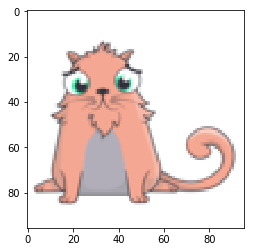

In [6]:
plt.imshow(image_db[0])

In [7]:
import keras.backend as K
from keras import Model
from keras.layers import Add, LeakyReLU, UpSampling2D, Flatten, AveragePooling2D, Reshape, Input, Dense, Conv2D, Conv2DTranspose, concatenate, Lambda, Dropout, MaxPooling2D, Concatenate, BatchNormalization, SeparableConv2D, Activation
from keras.optimizers import Adam
from keras.regularizers import l2

### Generator

Take some random noise vector and output an image

In [9]:
import tensorflow as tf

In [10]:
tf.reset_default_graph()
K.clear_session()
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [50]:
def generator():
    _input = Input((64,), dtype = np.float32)
    
    X = Dense(1024,activation=None,kernel_initializer='he_normal')(_input)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    X = Reshape((8,8,-1))(X) #8*8 * 16
    
    X = Conv2DTranspose(24, (6, 6), strides=(3, 3),kernel_initializer='he_normal', padding='same') (X)
    X = Conv2D(24, (5, 5),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = Activation('elu')(X)
    
    X = Conv2DTranspose(48, (4, 4), strides=(2, 2),kernel_initializer='he_normal', padding='same') (X)
    X = Conv2D(48, (5, 5),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = Activation('elu')(X)
    
    X = Conv2DTranspose(80, (4,4), strides=(2, 2),kernel_initializer='he_normal', padding='same') (X)
    X = Conv2D(80, (5, 5),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = Activation('elu')(X)
        
    X = Conv2D(112, (5, 5),kernel_initializer='he_normal',padding='same') (X)
    X = BatchNormalization()(X)
    X = Activation('elu')(X)
    
    #X = Dropout(.1)(X)
    
    X = Conv2D(3, (1, 1), kernel_initializer='he_normal', padding='same') (X)
    X = BatchNormalization()(X)
    X = Activation('sigmoid')(X)
    
    model = Model(inputs = [_input], outputs=[X])
    return model

gen = generator()
gen.compile('adam', loss='mean_squared_error')
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              66560     
_________________________________________________________________
batch_normalization_67 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_transpose_22 (Conv2DT (None, 24, 24, 24)        13848     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 24, 24, 24)        14424     
__________

In [57]:
def discriminator():
    _input = Input( (96,96,3), dtype = np.float32)
    
    X = Conv2D(24, (5, 5),kernel_initializer='he_normal', padding='same') (_input)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = AveragePooling2D((2,2))(X) #48
      
    X = Conv2D(48, (5, 5),kernel_initializer='he_normal', padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = AveragePooling2D((2,2))(X) #24
    
    X = Conv2D(80, (5, 5), kernel_initializer='he_normal', padding='same') (X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    X = AveragePooling2D((2,2))(X) #16
      
    X = Flatten()(X)
    #X = Dropout(.1)(X)
    
    X = Dense(122,kernel_initializer='he_normal',)(X)
    X = BatchNormalization()(X)
    X = LeakyReLU()(X)
    
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=[_input], outputs=[X])
    return model

disc = discriminator()
opt = Adam(1e-5)
disc.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])
disc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 96, 96, 24)        1824      
_________________________________________________________________
batch_normalization_83 (Batc (None, 96, 96, 24)        96        
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 96, 96, 24)        0         
_________________________________________________________________
average_pooling2d_22 (Averag (None, 48, 48, 24)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 48, 48, 48)        28848     
_________________________________________________________________
batch_normalization_84 (Batc (None, 48, 48, 48)        192       
__________

In [51]:
def combined_network(gen, disc):
    
    _input = Input( (64,), dtype=np.float32)
    
    disc.trainable = False
    
    X = gen(_input)
    X = disc(X)
    
    model = Model(inputs = [_input], outputs=[X])
    return model
    
comb = combined_network(gen, disc)
comb.compile('adam', loss='binary_crossentropy')

In [59]:
def group_cats(data,N=4, M=4):
    z = np.zeros((N*96,M*96,3))
    k=0
    for i in range(N):
        for j in range(M):
            z[i*96:(i+1)*96, j*96:(j+1)*96,:] = data[k]
            k+=1
    return np.clip(z,0,1)

def save_model(filename):
    global gen
    global disc
    
    tfjs.converters.save_keras_model(gen, filename)

    with open('gen'+filename+'.json','w') as f:
        f.write(gen.to_json())
        gen.save_weights('gen'+filename+'.h5')

    with open('disc'+filename+'.json','w') as f:
        f.write(disc.to_json())
        disc.save_weights('disc'+filename+'.h5')
    
    #fix the json 
    with open(filename+'/model.json','r') as f:
        data = json.loads(f.read())
    
    data['modelTopology']['model_config']['config']['layers'][0]['config']['batch_input_shape']=[1,64]
    
    with open(filename+'/model.json','w') as f:
        f.write(json.dumps(data))
        
    print('saved, ', filename)

In [60]:
def disc_batch(mode, batch_size = 32, alpha=.05):
    global image_db
    global gen
    
    if mode=='positive':
        v =  np.random.normal(0,1,(batch_size,64))
        X = gen.predict(v)
        Y = np.zeros(batch_size)+alpha
           
    elif mode =='negative':
        idx = np.random.choice(len(image_db),size=batch_size, replace=False)
        real_images = image_db[idx]
        X = real_images
        Y = (1-alpha)*np.ones(batch_size)
        
    return X,Y

def gen_batch(batch_size=32):
    X = np.random.normal(0,1,(batch_size,64))
    Y = np.ones(batch_size)
    return X,Y

In [61]:
gen = generator()
gen.compile('adam', loss='mean_squared_error')

disc = discriminator()
opt = Adam(5e-4)
disc.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

comb = combined_network(gen, disc)
comb.compile('adam', loss='binary_crossentropy',metrics=['accuracy'])

In [62]:
scores=[]
epoch_size = 500
v = np.random.multivariate_normal(np.zeros(64),np.eye(64),16)

In [63]:
#gen.load_weights('genv2.h5')
#disc.load_weights('discv2.h5')

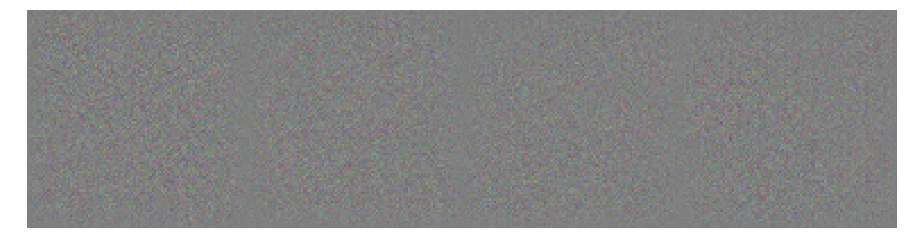

0 499 0.6418695 0.625 0.6901973 0.625 0.73246384 0.28125
saved,  v2_0


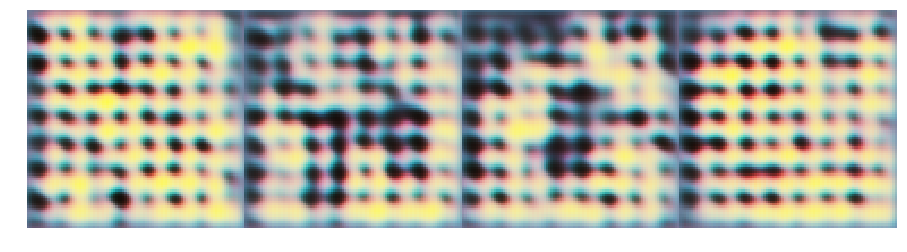

1 499 0.59754395 0.75 0.63189405 0.875 0.7734049 0.25
saved,  v2_0


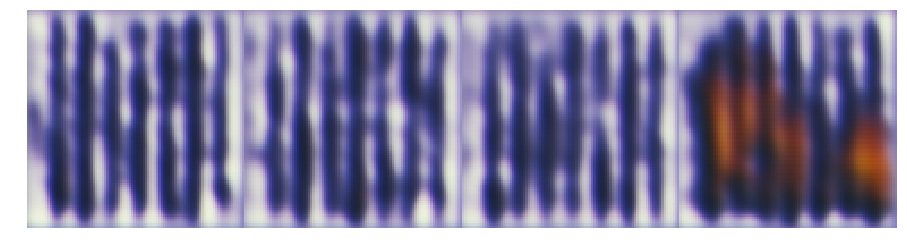

2 499 0.6002164 0.625 0.7796547 0.375 0.8194529 0.3125
saved,  v2_0


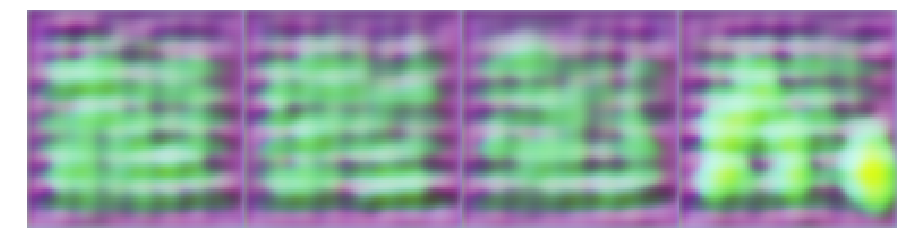

3 499 0.799762 0.625 0.58544827 0.875 0.7428692 0.59375
saved,  v2_0


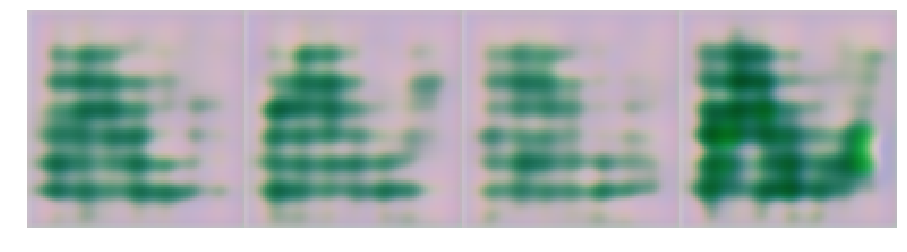

4 499 0.58937883 0.625 0.54853845 0.75 0.905653 0.125
saved,  v2_0


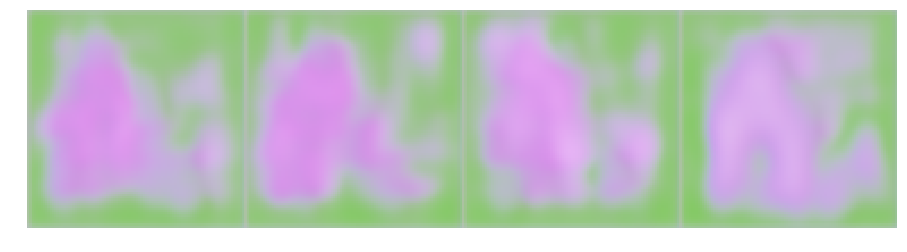

5 499 0.611374 0.625 0.74686724 0.375 0.6514063 0.71875
saved,  v2_0


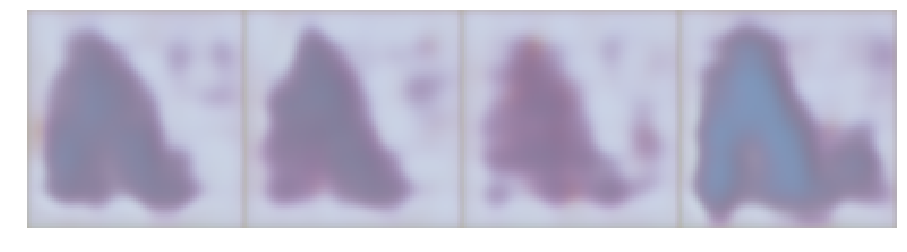

6 499 0.677629 0.625 0.80712825 0.375 0.68389094 0.5
saved,  v2_0


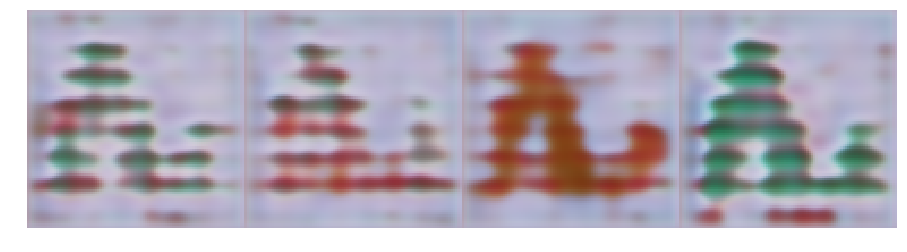

7 499 0.58505523 0.75 0.6697739 0.25 0.64674896 0.59375
saved,  v2_0


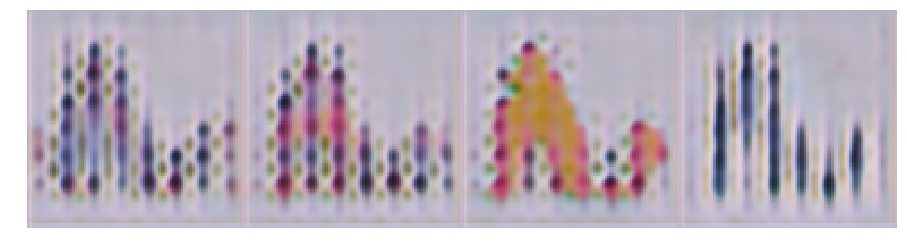

8 499 0.59467435 0.875 0.52593184 1.0 0.7325845 0.375
saved,  v2_0


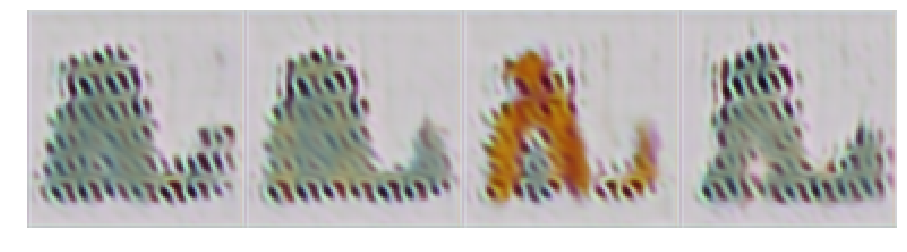

9 499 0.54968226 0.75 0.56721497 0.875 0.88365 0.1875
saved,  v2_0


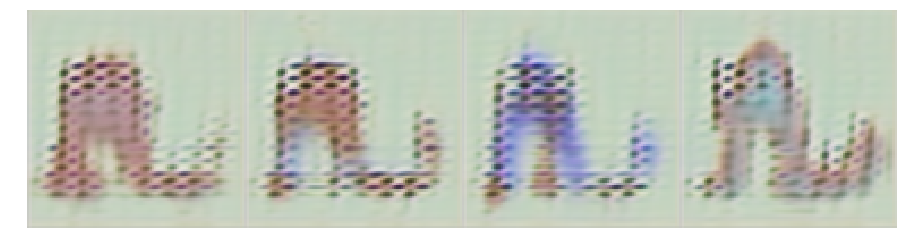

10 499 0.56305623 0.625 0.8011686 0.25 0.88384813 0.25
saved,  v2_1


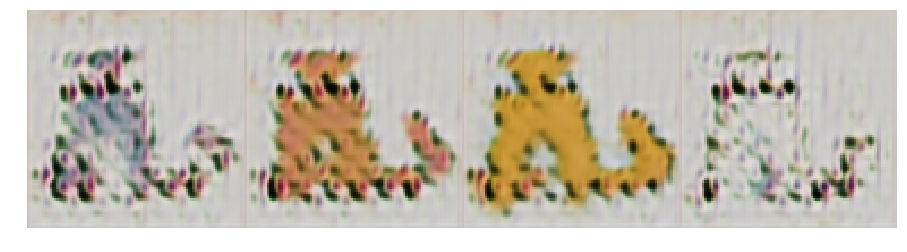

11 499 0.57801515 0.875 0.7441088 0.375 0.88446075 0.09375
saved,  v2_1


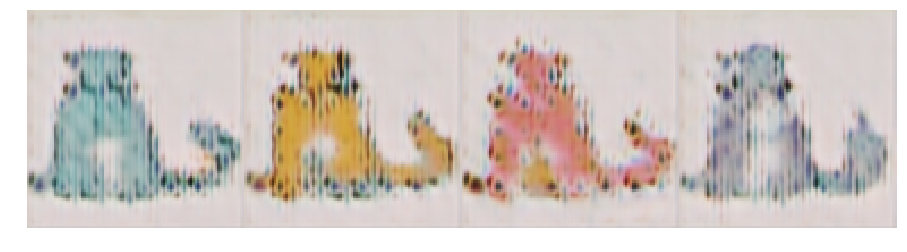

12 499 0.53919995 0.75 0.6447401 0.625 0.8660468 0.15625
saved,  v2_1


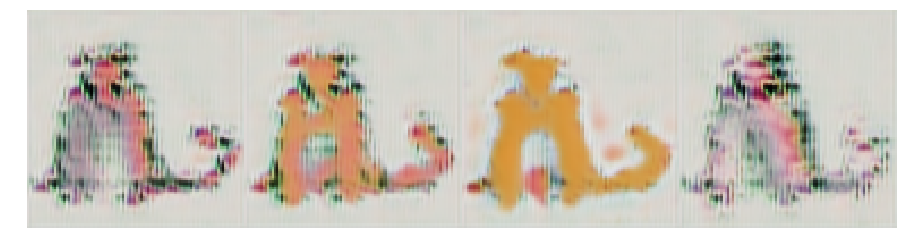

13 499 0.47280657 0.875 0.7180802 0.375 0.9091426 0.15625
saved,  v2_1


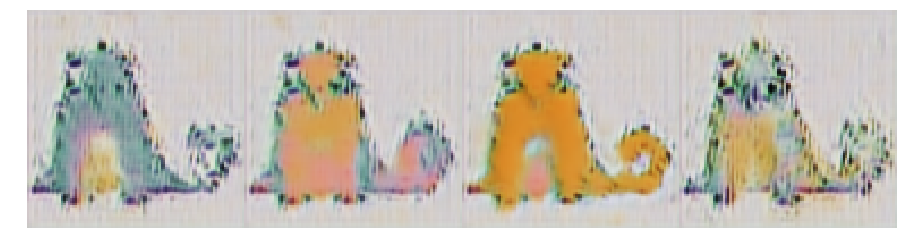

14 499 0.5285442 0.75 0.64010197 0.625 0.750087 0.3125
saved,  v2_1


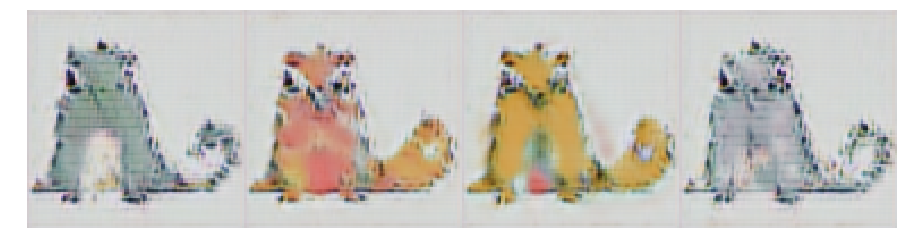

15 499 0.42380106 1.0 0.85114264 0.375 1.0309447 0.03125
saved,  v2_1


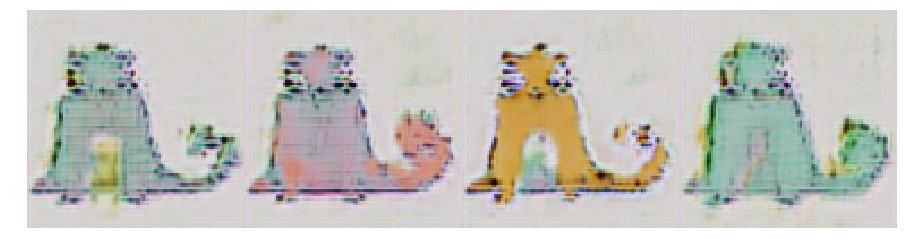

16 499 0.4646723 1.0 0.6389132 0.75 0.6661358 0.75
saved,  v2_1


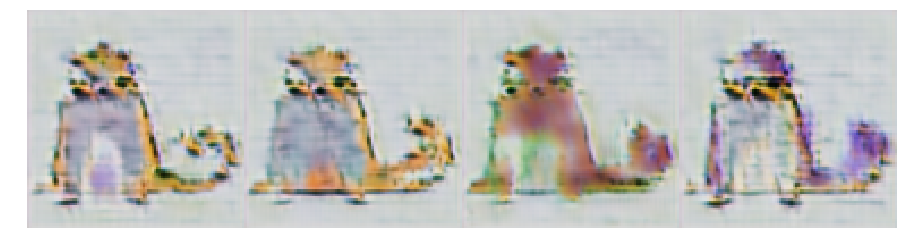

17 499 0.42583618 1.0 0.8883561 0.125 1.0081179 0.03125
saved,  v2_1


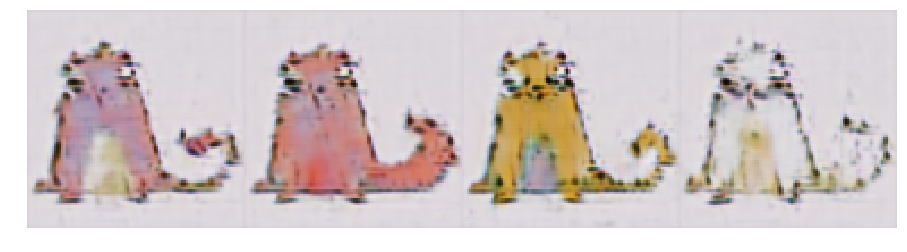

18 499 0.55060714 0.625 0.61260974 0.625 0.75455076 0.3125
saved,  v2_1


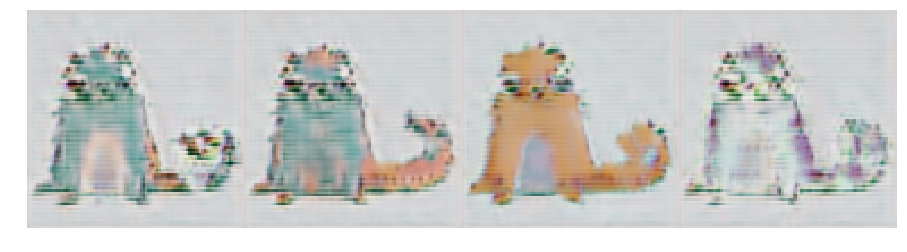

19 499 0.5508948 0.875 0.6249203 0.75 0.8339091 0.3125
saved,  v2_1


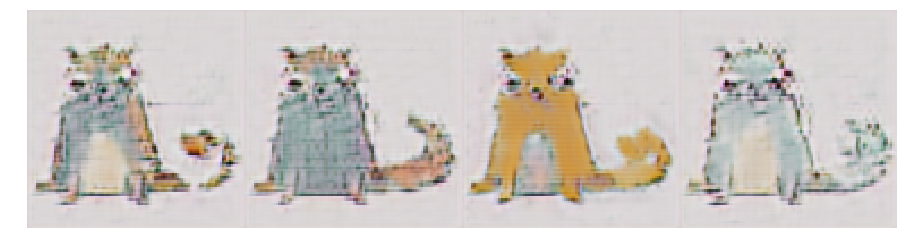

20 499 0.56056917 0.75 0.5974872 0.625 0.94225854 0.40625
saved,  v2_2


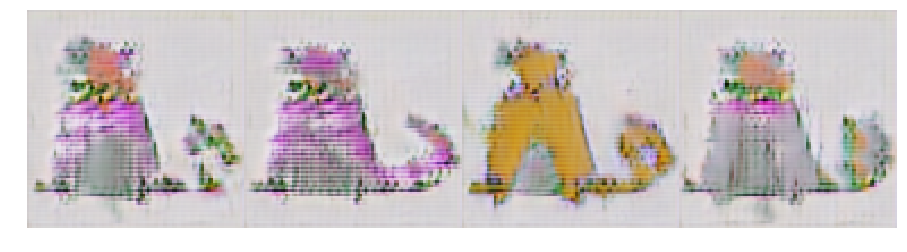

21 499 0.49703187 1.0 0.76264673 0.5 0.9252086 0.03125
saved,  v2_2


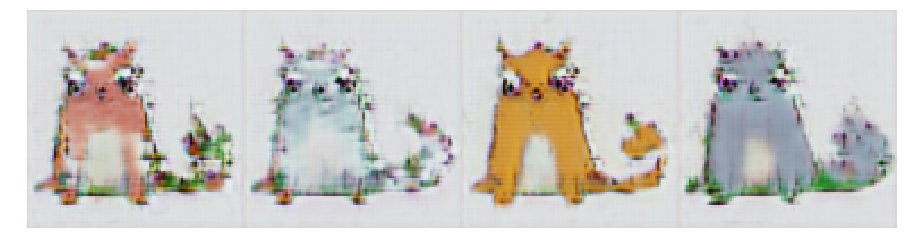

22 499 0.6721531 0.875 0.67541873 0.5 0.77271926 0.40625
saved,  v2_2


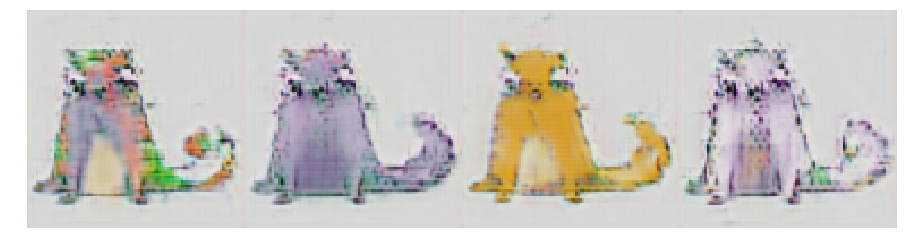

23 499 0.4274261 1.0 0.49764377 0.75 0.70667714 0.46875
saved,  v2_2


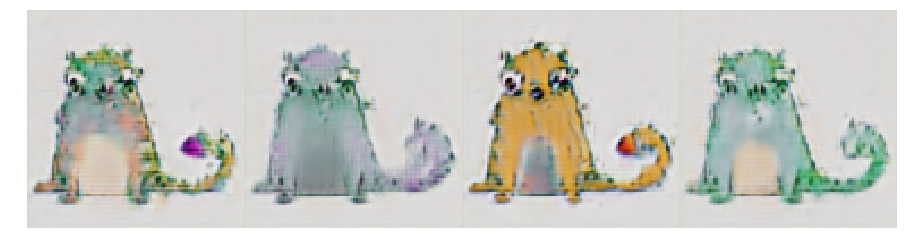

24 499 0.37245336 1.0 0.6506716 0.625 0.6624266 0.59375
saved,  v2_2


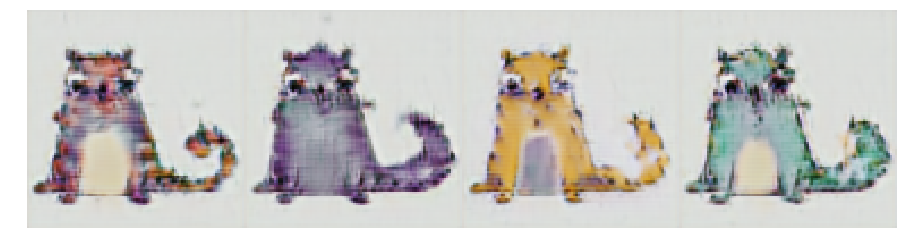

25 499 0.5717057 0.75 0.50096047 0.875 0.8987218 0.25
saved,  v2_2


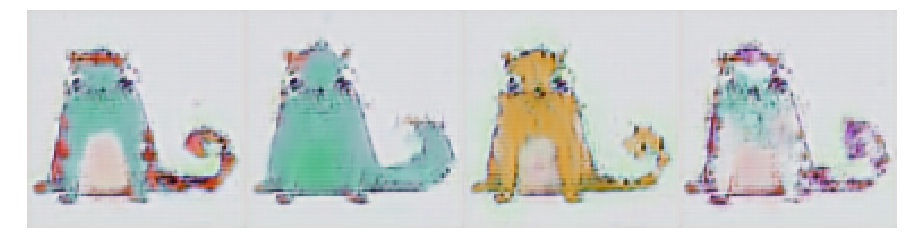

26 499 0.42078036 0.875 0.4541062 1.0 0.7796859 0.375
saved,  v2_2


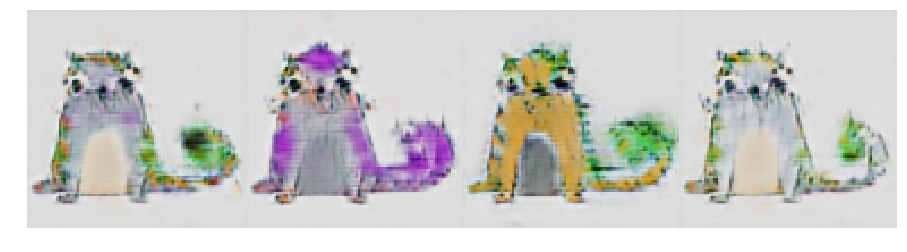

27 499 0.41357517 0.875 0.6567397 0.5 0.4297711 0.875
saved,  v2_2


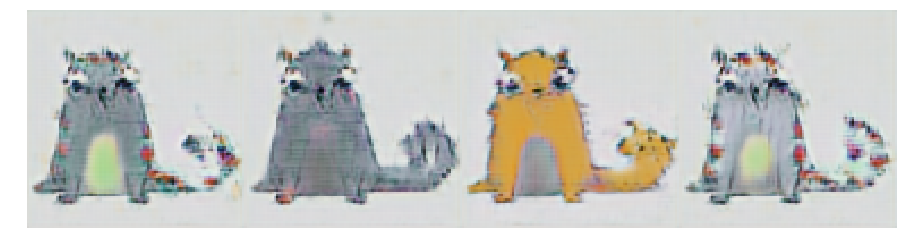

28 499 0.53654325 0.75 0.4418563 0.875 0.6741972 0.59375
saved,  v2_2


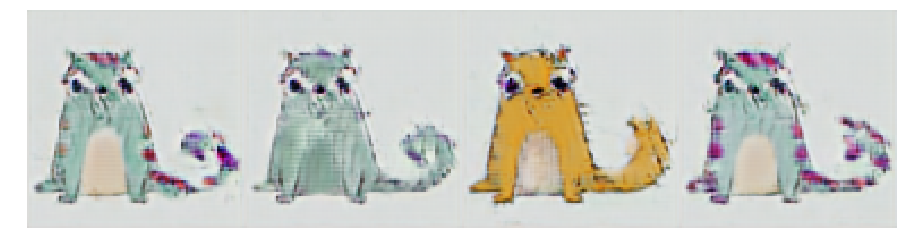

29 499 0.2411425 1.0 0.8061267 0.625 1.1808699 0.0625
saved,  v2_2


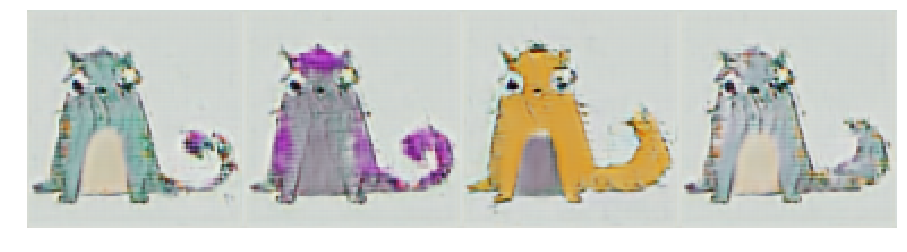

30 499 0.57307917 0.5 0.4917186 0.875 0.6060939 0.71875
saved,  v2_3


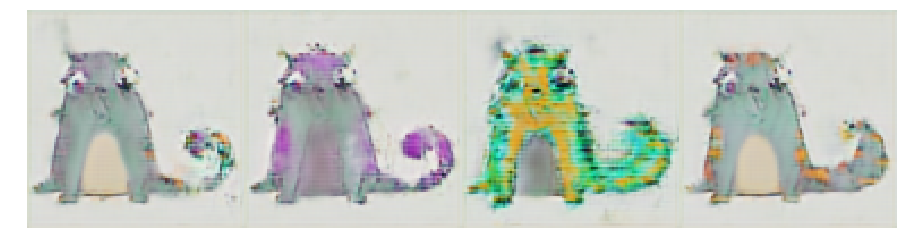

31 499 0.3002374 1.0 0.88036263 0.375 0.7427815 0.5
saved,  v2_3


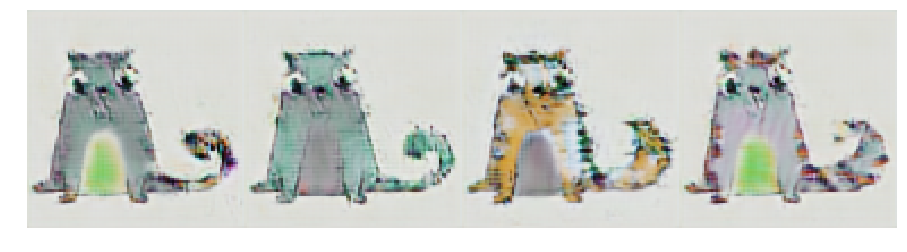

32 499 0.7453395 0.5 0.44933784 0.875 0.6270976 0.8125
saved,  v2_3


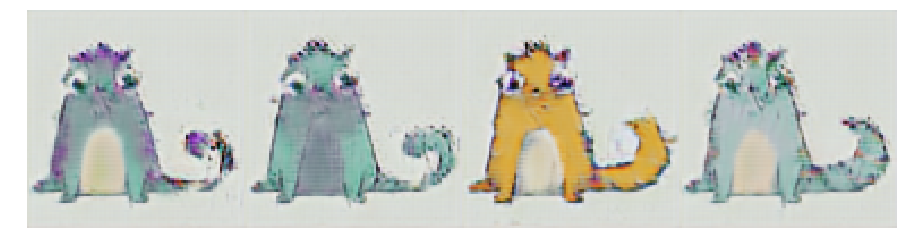

33 499 0.39474583 1.0 0.644239 0.625 0.6768579 0.71875
saved,  v2_3


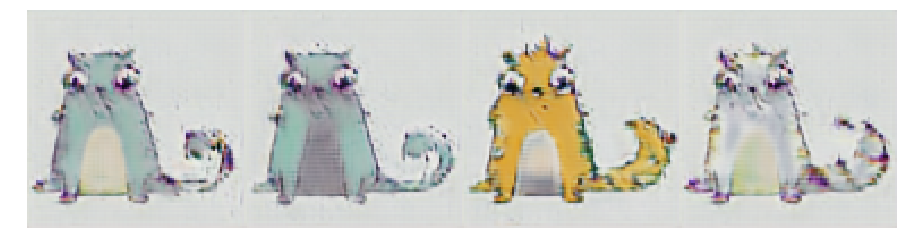

34 499 0.6928878 0.625 0.7202628 0.375 1.0935688 0.03125
saved,  v2_3


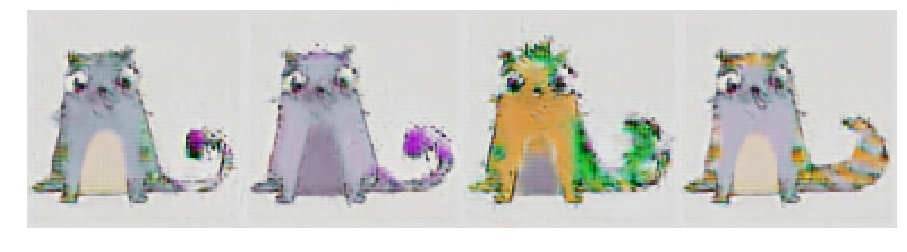

35 499 0.4546578 0.875 0.61247313 0.75 0.8176153 0.34375
saved,  v2_3


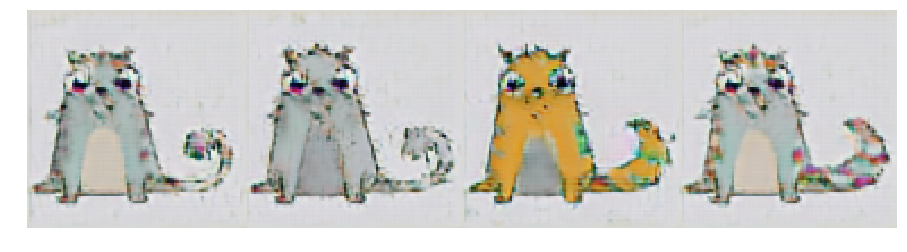

36 499 0.34420347 1.0 0.47297597 0.75 0.9174737 0.21875
saved,  v2_3


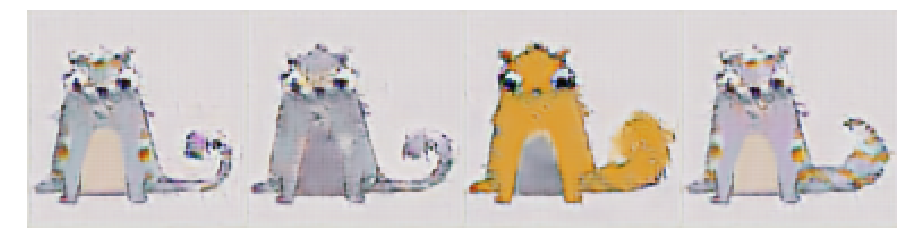

37 499 0.3969136 1.0 0.3781766 1.0 0.8455833 0.5
saved,  v2_3


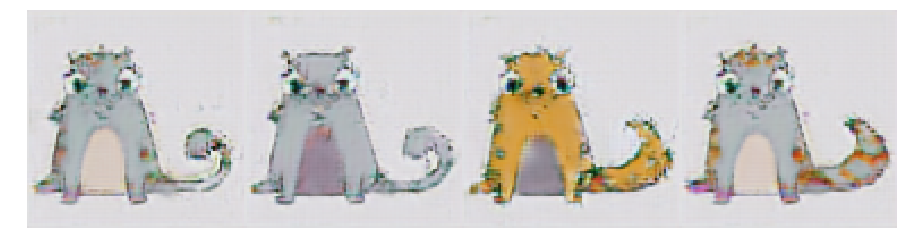

38 499 0.521734 0.875 0.66500884 0.5 0.7928009 0.40625
saved,  v2_3


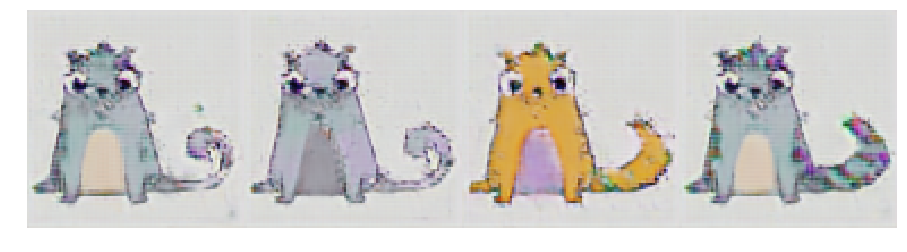

39 499 0.3882141 0.875 0.8200451 0.75 1.1626258 0.09375
saved,  v2_3


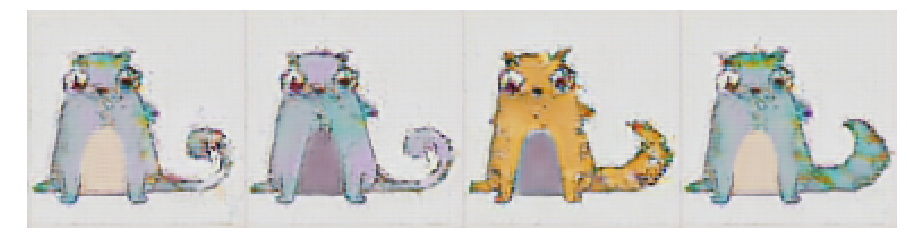

40 499 0.4863463 0.875 0.81405014 0.5 0.6229603 0.625
saved,  v2_4


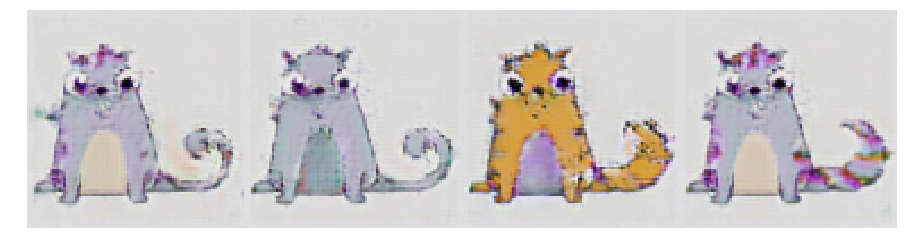

41 499 0.54488194 0.75 0.5871945 0.75 0.86743724 0.40625
saved,  v2_4


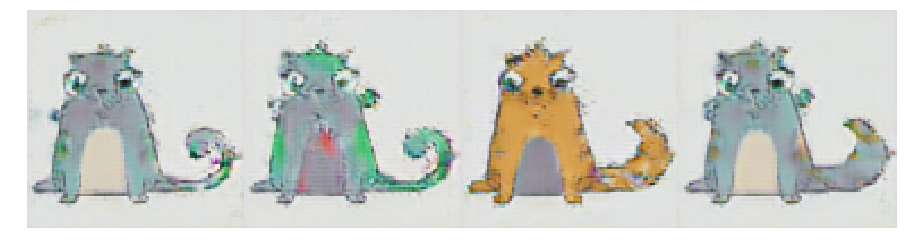

42 499 0.5005842 0.75 0.5309174 0.875 0.98273975 0.21875
saved,  v2_4


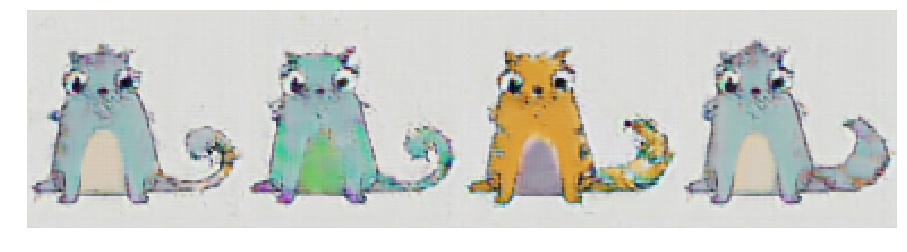

43 499 0.51268977 0.875 0.5596454 0.75 0.8647358 0.40625
saved,  v2_4


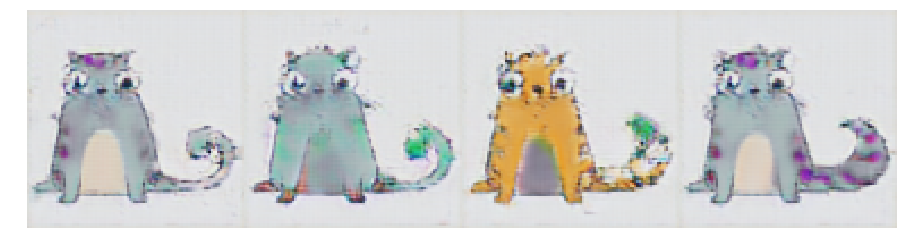

44 499 0.52236307 0.875 0.37674358 0.75 0.8477441 0.375
saved,  v2_4


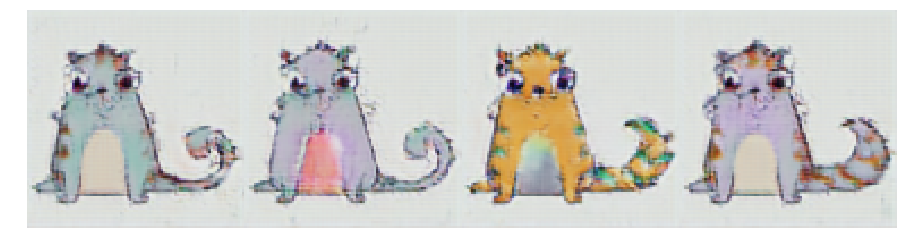

45 499 0.3648798 1.0 0.52020836 0.75 0.9878527 0.21875
saved,  v2_4


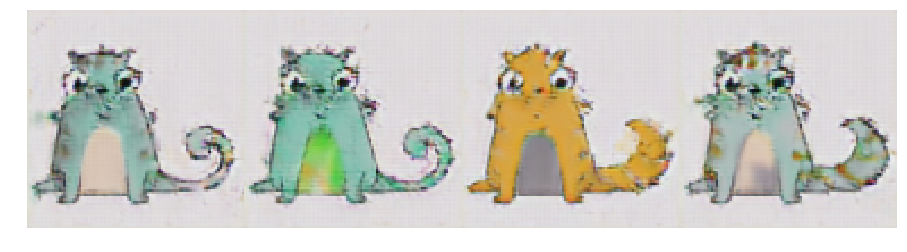

46 499 0.34449124 1.0 0.6793554 0.375 0.7972744 0.375
saved,  v2_4


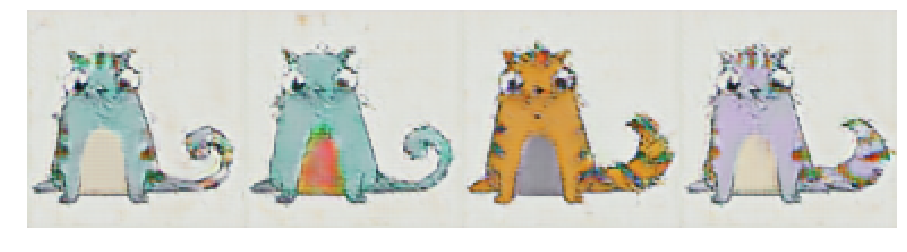

47 499 0.6634741 0.5 0.35311213 1.0 0.68584085 0.65625
saved,  v2_4


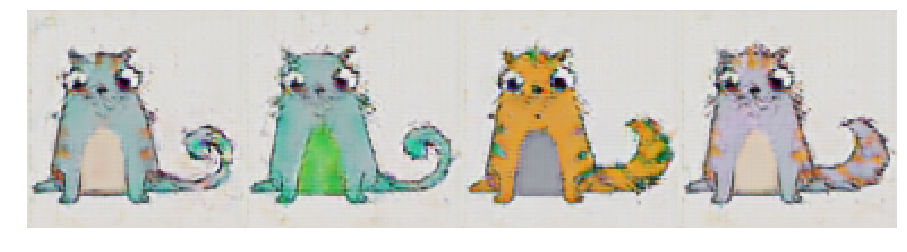

48 499 0.40127033 1.0 0.3428055 0.875 0.75725436 0.65625
saved,  v2_4


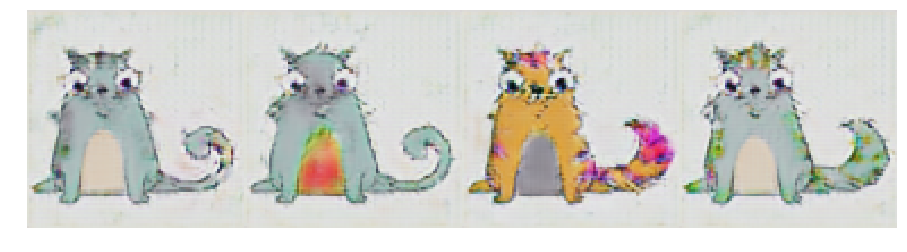

49 499 0.23571354 1.0 0.30876848 1.0 0.8126971 0.34375
saved,  v2_4


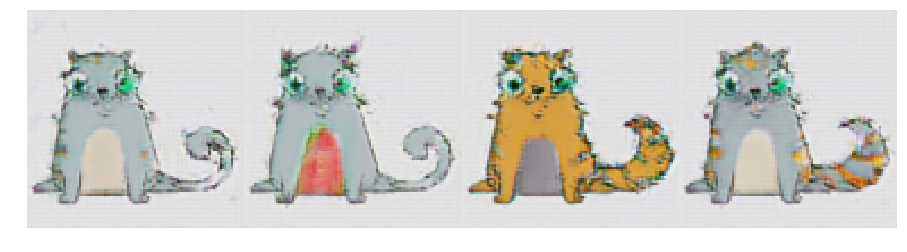

50 499 0.2922356 1.0 0.7203258 0.75 0.9225265 0.21875
saved,  v2_5


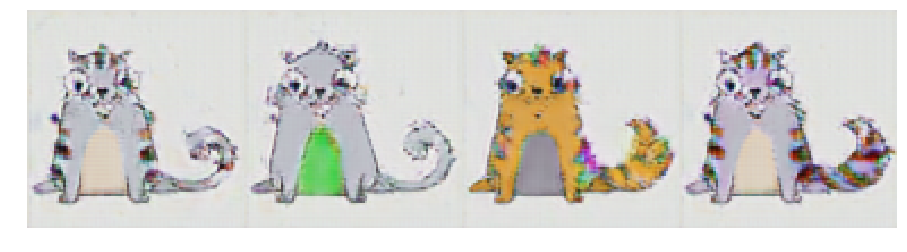

51 499 0.6273241 0.875 0.5450659 0.625 0.9297285 0.28125
saved,  v2_5


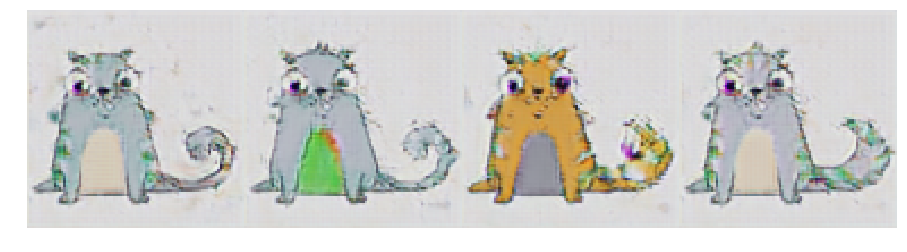

52 499 0.7126962 0.5 0.42475647 0.875 0.5821104 0.78125
saved,  v2_5


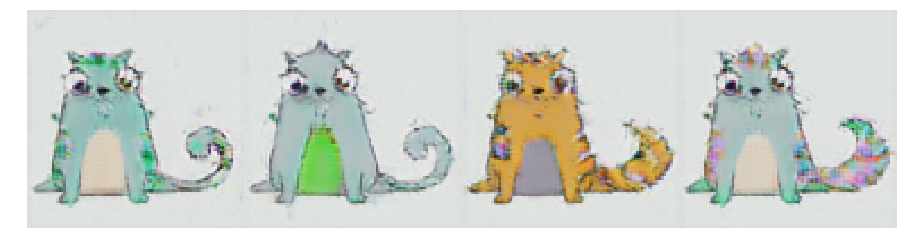

53 499 0.4142962 0.875 0.52608883 1.0 0.9593239 0.34375
saved,  v2_5


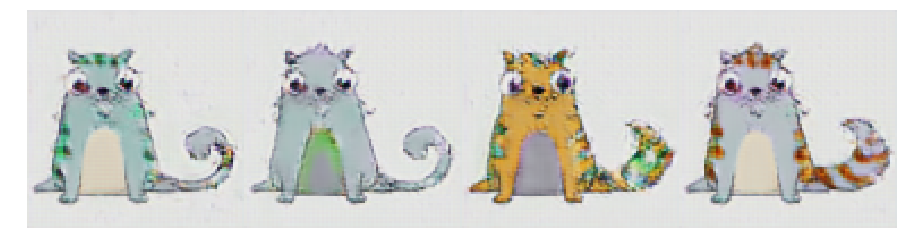

54 499 0.27135444 0.875 0.8663741 0.375 0.5950601 0.71875
saved,  v2_5


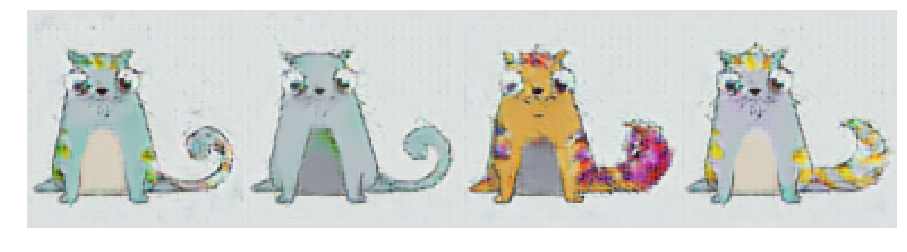

55 499 0.35475507 1.0 0.46610835 0.75 1.0608245 0.1875
saved,  v2_5


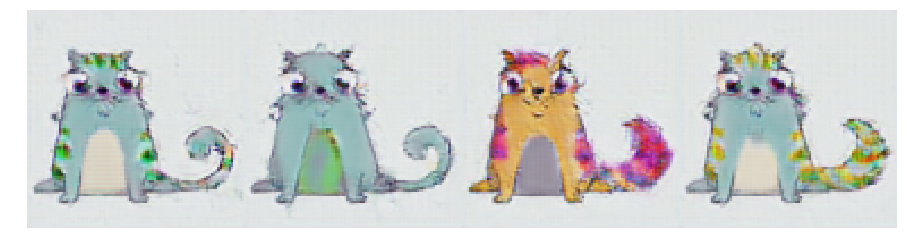

56 499 0.5076111 0.875 0.46446386 1.0 1.1606538 0.09375
saved,  v2_5


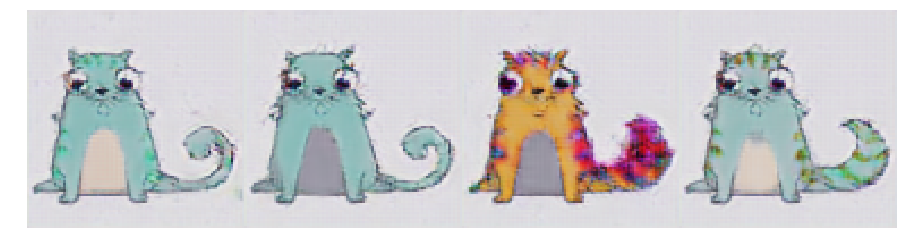

57 499 0.37855506 1.0 0.3956704 0.875 1.052034 0.1875
saved,  v2_5


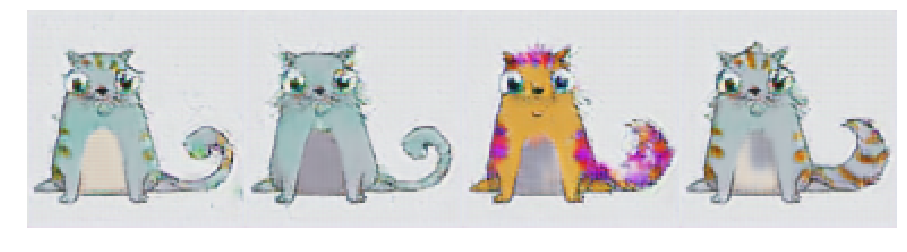

58 499 0.2735204 0.875 0.43526143 1.0 1.2816391 0.09375
saved,  v2_5


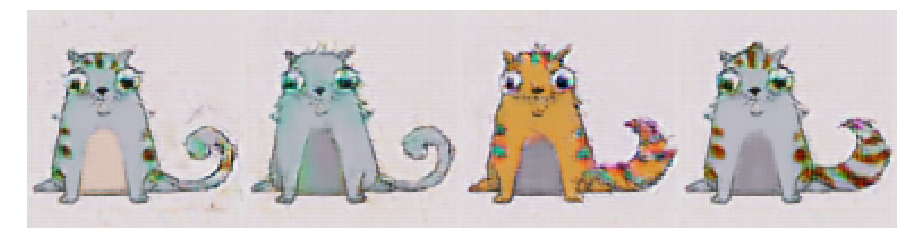

59 499 0.43436128 1.0 0.36747098 0.875 0.8158262 0.34375
saved,  v2_5


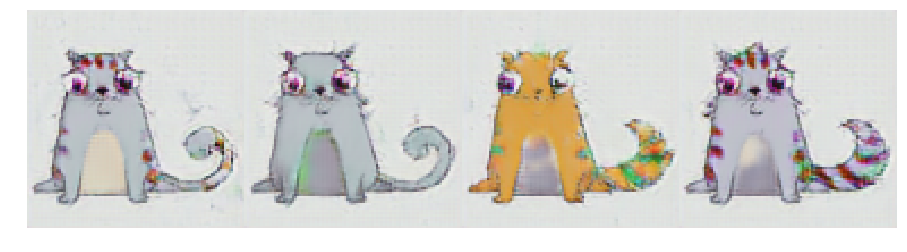

60 499 0.20759884 1.0 0.3452084 0.875 1.3030663 0.21875
saved,  v2_6


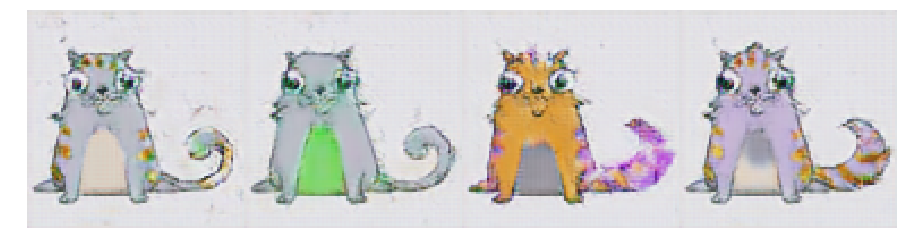

61 499 0.2936043 1.0 0.46675813 0.75 0.8585821 0.375
saved,  v2_6


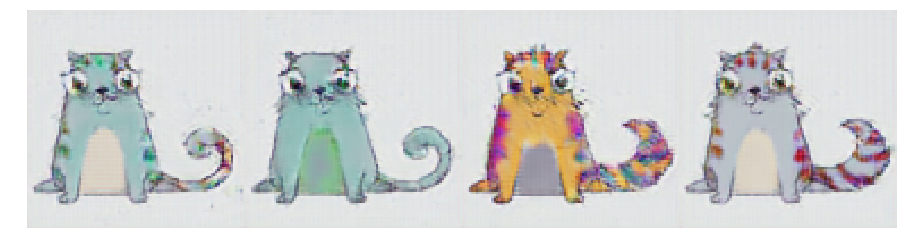

62 499 0.44609606 0.75 0.3587927 1.0 0.67858493 0.59375
saved,  v2_6


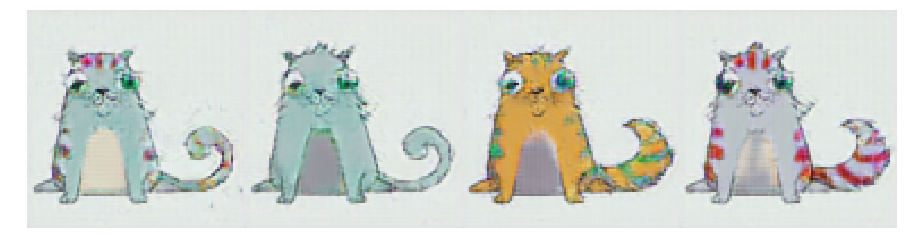

In [ ]:
for i in range(101):
    
    test = gen.predict(v)
    z = group_cats(test,4,4)
    imsave('cats2/'+str(i)+'.png', z)

    plt.figure(figsize=(16,4))
    plt.imshow(z[0:96,:,:])
    plt.axis('off')
    plt.show()

    
    for k in range(epoch_size):
        if k==epoch_size-1:
            alpha = 0
        else:
            alpha = .05
            
        disc.trainable = True

        X,Y = disc_batch(mode='positive',batch_size=8, alpha=0)
        dscore1 = disc.train_on_batch(X,Y)
        X,Y = disc_batch(mode='negative', batch_size=8, alpha=alpha)
        dscore2 = disc.train_on_batch(X,Y)
        
        disc.trainable = False
        X,Y = gen_batch(batch_size=32)
        cscore = comb.train_on_batch(X,Y)
        
    scores.append([i,k]+dscore1+dscore2 + cscore)

    print(*scores[-1])
    save_model('v2_'+str(i//10)) #new file every 10 epochs (checkpoint)

    


In [70]:
def pad_name(s):
    num = s.split('.png')[0]
    num = str(int(num))
        
    if int(num) < 10:
        num = '000'+num
    elif int(num) < 100:
        num =  '00' + num 
    elif int(num) < 1000:
        num =  '0' + num
    return num+'.png'

In [71]:
files = [f for f in os.listdir('cats2') if f.endswith('png')]
for f in files:
    os.rename('cats2/'+f, 'cats2/'+pad_name(f))

In [72]:
from subprocess import call

In [73]:
ops = ['ffmpeg','-y','-i','cats2/%4d.png', '-filter:v', 'setpts=2.0*PTS', '-pix_fmt', 'yuv420p','outputv3.mp4']
call(ops)


0

In [74]:
Video('outputv3.mp4')